In [1]:
pip install torch pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

<ipython-input-7-fac321632b78>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()  # Ensure hourly frequency
<ipython-input-7-fac321632b78>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill missing values


Epoch 1/50, Loss: 0.004035
Epoch 2/50, Loss: 0.002964
Epoch 3/50, Loss: 0.002792
Epoch 4/50, Loss: 0.002639
Epoch 5/50, Loss: 0.002570
Epoch 6/50, Loss: 0.002497
Epoch 7/50, Loss: 0.002448
Epoch 8/50, Loss: 0.002396
Epoch 9/50, Loss: 0.002385
Epoch 10/50, Loss: 0.002319
Epoch 11/50, Loss: 0.002306
Epoch 12/50, Loss: 0.002263
Epoch 13/50, Loss: 0.002228
Epoch 14/50, Loss: 0.002218
Epoch 15/50, Loss: 0.002174
Epoch 16/50, Loss: 0.002174
Epoch 17/50, Loss: 0.002144
Epoch 18/50, Loss: 0.002114
Epoch 19/50, Loss: 0.002093
Epoch 20/50, Loss: 0.002087
Epoch 21/50, Loss: 0.002060
Epoch 22/50, Loss: 0.002050
Epoch 23/50, Loss: 0.002033
Epoch 24/50, Loss: 0.002011
Epoch 25/50, Loss: 0.001999
Epoch 26/50, Loss: 0.001983
Epoch 27/50, Loss: 0.001963
Epoch 28/50, Loss: 0.001962
Epoch 29/50, Loss: 0.001942
Epoch 30/50, Loss: 0.001935
Epoch 31/50, Loss: 0.001919
Epoch 32/50, Loss: 0.001890
Epoch 33/50, Loss: 0.001890
Epoch 34/50, Loss: 0.001873
Epoch 35/50, Loss: 0.001855
Epoch 36/50, Loss: 0.001851
E

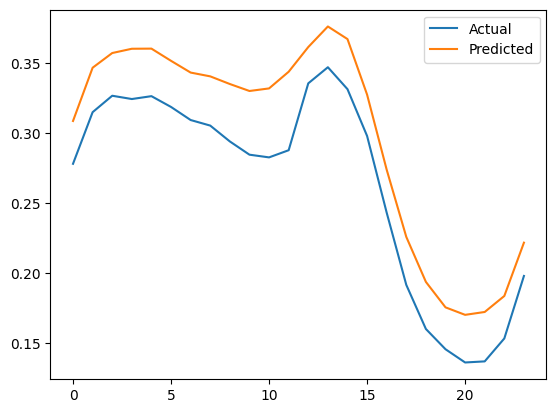

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Step 1: Load and Preprocess Dataset
def load_energy_data(csv_path):
    df = pd.read_csv(csv_path, parse_dates=['Datetime'], index_col='Datetime')
    df = df.resample('H').mean()  # Ensure hourly frequency
    df = df.fillna(method='ffill')  # Forward fill missing values
    return df

# Load dataset
csv_path = "/content/sorted_energy_data (2).csv"  # Update with your actual file path
data = load_energy_data(csv_path)
y = data['NI_MW'].values

# Normalize Data
y_min, y_max = y.min(), y.max()
y = (y - y_min) / (y_max - y_min)

# Step 2: Define TimeSeriesDataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length):
        self.data = data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

    def __len__(self):
        return len(self.data) - self.backcast_length - self.forecast_length

    def __getitem__(self, index):
        x = self.data[index : index + self.backcast_length]
        y = self.data[index + self.backcast_length : index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
backcast_length = 60
forecast_length = 24
batch_size = 32

# Create dataset
dataset = TimeSeriesDataset(y, backcast_length, forecast_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Step 3: Define N-BEATS Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(NBeatsBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        self.fc4 = nn.Linear(hidden_units, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

class NBeats(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_blocks):
        super(NBeats, self).__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, hidden_units, output_size) for _ in range(num_blocks)
        ])

    def forward(self, x):
        return sum(block(x) for block in self.blocks)

# Model Parameters
hidden_units = 128
num_blocks = 3
learning_rate = 0.001
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(input_size=backcast_length, hidden_units=hidden_units, output_size=forecast_length, num_blocks=num_blocks).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Step 4: Train the Model
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        forecast = model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")

# Step 5: Evaluate the Model
model.eval()
x_batch, y_batch = next(iter(dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)
with torch.no_grad():
    forecast = model(x_batch)

# Convert to numpy for plotting
import matplotlib.pyplot as plt
forecast = forecast.cpu().numpy()
y_batch = y_batch.cpu().numpy()
plt.plot(y_batch[0], label='Actual')
plt.plot(forecast[0], label='Predicted')
plt.legend()
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# Assuming `dataset` is your complete dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42)


In [10]:
from torch.utils.data import DataLoader

batch_size = 64  # Adjust based on your setup

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [14]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Ensure model is in evaluation mode
model.eval()

# Get predictions on the test set
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:  # Now, test_loader is properly defined
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Save the trained model
model_path = "nbeats_energy_forecasting.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")


MSE: 0.0016
RMSE: 0.0403
R² Score: 0.9198
MAPE: inf%
Model saved successfully at nbeats_energy_forecasting.pth


<ipython-input-14-7a218a3443e5>:28: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error


<ipython-input-15-386b6b8fd3fd>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()  # Ensure hourly frequency
<ipython-input-15-386b6b8fd3fd>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill missing values


Epoch 1/100, Train Loss: 0.005242, Validation Loss: 0.003936
Epoch 2/100, Train Loss: 0.003128, Validation Loss: 0.003131
Epoch 3/100, Train Loss: 0.002906, Validation Loss: 0.002649
Epoch 4/100, Train Loss: 0.002794, Validation Loss: 0.002615
Epoch 5/100, Train Loss: 0.002688, Validation Loss: 0.002423
Epoch 6/100, Train Loss: 0.002604, Validation Loss: 0.002501
Epoch 7/100, Train Loss: 0.002563, Validation Loss: 0.002480
Epoch 8/100, Train Loss: 0.002491, Validation Loss: 0.002355
Epoch 9/100, Train Loss: 0.002452, Validation Loss: 0.002392
Epoch 10/100, Train Loss: 0.002454, Validation Loss: 0.002289
Epoch 11/100, Train Loss: 0.002385, Validation Loss: 0.002216
Epoch 12/100, Train Loss: 0.002357, Validation Loss: 0.002676
Epoch 13/100, Train Loss: 0.002323, Validation Loss: 0.002274
Epoch 14/100, Train Loss: 0.002290, Validation Loss: 0.002209
Epoch 15/100, Train Loss: 0.002295, Validation Loss: 0.002254
Epoch 16/100, Train Loss: 0.002248, Validation Loss: 0.002379
Epoch 17/100, Tra

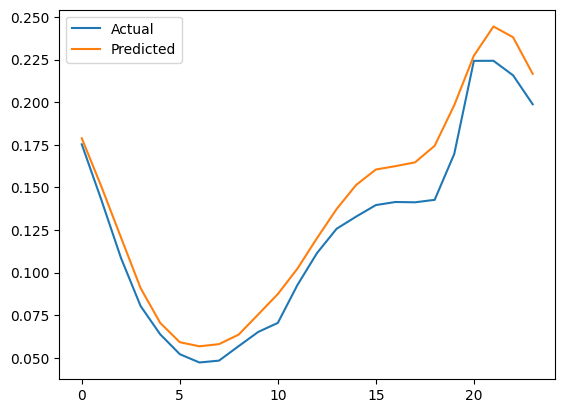

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Step 1: Load and Preprocess Dataset
def load_energy_data(csv_path):
    df = pd.read_csv(csv_path, parse_dates=['Datetime'], index_col='Datetime')
    df = df.resample('H').mean()  # Ensure hourly frequency
    df = df.fillna(method='ffill')  # Forward fill missing values
    return df

# Load dataset
csv_path = "/content/sorted_energy_data (2).csv"  # Update with your actual file path
data = load_energy_data(csv_path)
y = data['NI_MW'].values

# Normalize Data
y_min, y_max = y.min(), y.max()
y = (y - y_min) / (y_max - y_min)

# Step 2: Define TimeSeriesDataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length):
        self.data = data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

    def __len__(self):
        return len(self.data) - self.backcast_length - self.forecast_length

    def __getitem__(self, index):
        x = self.data[index : index + self.backcast_length]
        y = self.data[index + self.backcast_length : index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Parameters
backcast_length = 60
forecast_length = 24
batch_size = 64

# Create dataset
dataset = TimeSeriesDataset(y, backcast_length, forecast_length)

# Split the dataset into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Define N-BEATS Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(NBeatsBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        self.fc4 = nn.Linear(hidden_units, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

class NBeats(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_blocks):
        super(NBeats, self).__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, hidden_units, output_size) for _ in range(num_blocks)
        ])

    def forward(self, x):
        return sum(block(x) for block in self.blocks)

# Model Parameters
hidden_units = 128
num_blocks = 3
learning_rate = 0.001
epochs = 100
patience = 10  # Early stopping patience

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(input_size=backcast_length, hidden_units=hidden_units, output_size=forecast_length, num_blocks=num_blocks).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Step 4: Train the Model with Early Stopping
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        forecast = model(x_batch)
        loss = criterion(forecast, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            forecast = model(x_batch)
            loss = criterion(forecast, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Step 5: Evaluate the Model on Test Data
model.eval()
x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)
with torch.no_grad():
    forecast = model(x_batch)

# Convert to numpy for plotting
import matplotlib.pyplot as plt
forecast = forecast.cpu().numpy()
y_batch = y_batch.cpu().numpy()
plt.plot(y_batch[0], label='Actual')
plt.plot(forecast[0], label='Predicted')
plt.legend()
plt.show()


In [16]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Ensure model is in evaluation mode
model.eval()

# Get predictions on the test set
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:  # Now, test_loader is properly defined
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
epsilon = 1e-8  # A small value to prevent division by zero
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Save the trained model
model_path = "nbeats_energy_forecasting.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")


MSE: 0.0015
RMSE: 0.0390
R² Score: 0.9237
MAPE: inf%
Model saved successfully at nbeats_energy_forecasting.pth


<ipython-input-16-7a218a3443e5>:28: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error


In [19]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Ensure model is in evaluation mode
model.eval()

# Get predictions on the test set
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:  # Now, test_loader is properly defined
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(y_pred.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
epsilon = 1e-8  # A small value to prevent division by zero
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Save the trained model
model_path = "nbeats_energy_forecasting.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")


MSE: 0.0015
RMSE: 0.0390
R² Score: 0.9237
MAPE: 3799.56%
Model saved successfully at nbeats_energy_forecasting.pth
